In [1]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
import os
import glob
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
"""
Helper functions.
"""

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def pad(arr,windowSize):
    
    """
    Pads array to be divisible by window size.
    """
    
    divisible = False
    while divisible == False:
        if  arr.shape[0] % windowSize != 0:
            arr = np.pad(arr,((0,2),(0,0)),"constant")
        if  arr.shape[1] % windowSize != 0:
            arr = np.pad(arr,((0,0),(0,2)),"constant")

        if all([dim % windowSize ==0 for dim in arr.shape])==True:
                divisible = True
    return arr

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0] -1 
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0] -1 
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block==255).astype("float64")/block.size # Calculates percentage of array = 255.

def removeFiles(path):
    """
    Remove all files in a path.
    """
    files = glob.glob(path+"*")
    for f in files:
        os.remove(f)
        
    
#Remove black
def removeBlack(img,blackThresh):
    img
    black = np.logical_and.reduce((img[:,:,0] > blackThresh,
                                   img[:,:,1] > blackThresh,
                                   img[:,:,2] > blackThresh, 
                                   img[:,:,3] > blackThresh))
    black4 = np.dstack([black for i in range(3)])
    img[np.logical_not(black4)] = mstats.mode(img[:,:,:3],axis=None)[0]

In [71]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            
        #self.level = closestLevel(self.her2.level_dimensions,1000)
        self.level = 6
        self.lowResDims,self.lowResDimsHE = [x.level_dimensions[self.level] for x in [self.her2,self.he]] #3 is arbitrary but works
        self.lowResRGB, self.lowResRGBHE = [np.asarray(x[0].read_region((0,0),
                    self.level,(x[1][0],x[1][1]))).copy() for x in [(self.her2,self.lowResDims),
                                                                                          (self.he,self.lowResDimsHE)]] 


        #[removeBlack(img,blackThresh) for img in [self.lowResRGB,self.lowResRGBHE]]
        
        
        self.lowRes, self.lowResHE = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in self.lowResRGB, self.lowResRGBHE]  # Grayscale
        self.mode, self.modeHE = [mstats.mode(img,axis=None)[0] for img in [self.lowRes, self.lowResHE]]
        
        # Thresholded image
        def thresh(img,threshMargin,blurSize):
            img = cv2.GaussianBlur(img,(blurSize,blurSize),0)
            _,thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-threshMargin,255,1)
            return thresh
        self.thresh, self.threshHE = [thresh(img,threshMargin,blurSize) for img in [self.lowRes, self.lowResHE]]
        
        # Padd lowRes image and thresholded to make factors
        nrows = ncols = upscaleWindowSize/np.power(2,self.level-upscaleLevel)
        self.lowRes, self.thresh = [pad(arr,nrows) for arr in (self.lowRes, self.thresh)]
        
        coordsX,coordsY = np.indices((self.lowRes.shape[0],self.lowRes.shape[1]))
        blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
        blocksThresh = blockshaped(self.thresh,nrows,ncols)
        blocksLowRes = blockshaped(self.lowRes,nrows,ncols)

        self.relaventCoords = [] # ROIs

        #featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
        featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
        for block in featureBlocks:
            self.relaventCoords.append((blocksX[block],blocksY[block]))
        
    def show(self):
        
        plt.imshow(self.lowResRGB)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        plt.imshow(self.thresh,cmap=cm.gray)
        plt.show()
             
    def regionGen(self,upscaleLevel,colour=False): 
        for i in range(len(self.relaventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            if colour==True:
                thickness = 20
            else:
                thickness = 2
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), thickness)
            region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
            


In [4]:
numberOfRegions = []
imagesWithLines = [84,82,35]


# Hyperparams
threshArea = 0.25
threshMargin = 8

save = 0
show = 1
displayProb = 0.01
blackThresh = 120
blurSize = 47
upscaleLevels = [5]
writePath = "/home/msmith/her2/data/"
# CSV

groundTruth = pd.read_csv("data/groundTruth.csv")
cols = {1: "CaseNo", 2: "HeR2 SCORE",
       3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}
#groundTruth.sort_values(by=cols[3],inplace=True)



#Filter model params
def filterPaths ():
    writePath = "/home/msmith/her2/filter/data/"
    upscaleLevels = [5]
    threshArea = 0.25
    threshMargin = -40

Upscale level 5
Image 84 with score of 3, percScore of 70. Region sizes generated 128.


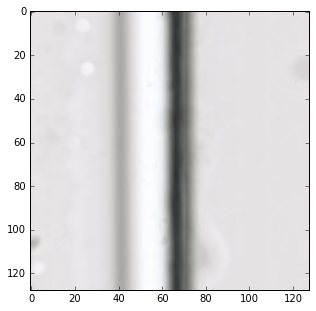

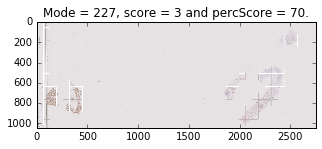

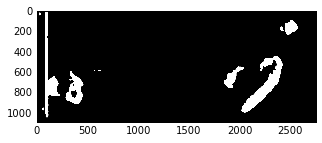

Number of regions generated at level 6 = 65 with dimension 128 x 128 x 3.
Image 82 with score of 3, percScore of 80. Region sizes generated 128.


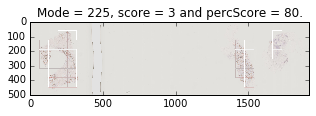

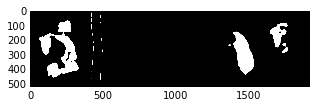

Number of regions generated at level 6 = 28 with dimension 128 x 128 x 3.
Image 35 with score of 3, percScore of 90. Region sizes generated 128.


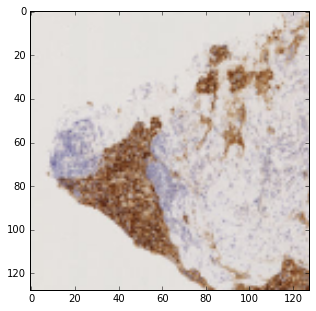

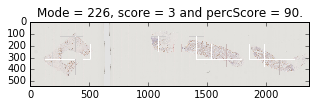

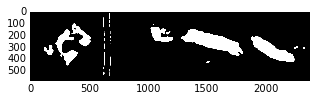

Number of regions generated at level 6 = 48 with dimension 128 x 128 x 3.
('Smallest y: ', 128)
('Smallets x: ', 128)
('Biggest y: ', 128)
('Biggest x: ', 128)
('Number of regions generated: ', [65, 28, 48])


In [5]:
if __name__ == "__main__":


    for upscaleLevel in upscaleLevels: # For each level
       
        upscaleWindowSize = np.power(2,12-upscaleLevel)
        print("==="*40)
        print("Upscale level %d" %upscaleLevel)
        print("==="*40)

        # Dimensions check
        dims = []

        # Generate ROIs and saave jpg
        #for caseNo in groundTruth.CaseNo.values[:]:
        for caseNo in imagesWithLines:

            nRegions = 0

            newpath = writePath + "roi_" + str(caseNo).zfill(3)  + "/" + str(upscaleLevel) + "/"
            if save == 1:
                removeFiles(newpath)
                if not os.path.exists(newpath):
                    os.makedirs(newpath)

            eg = her2Image(caseNo,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize)
            print("==="*40)
            print("==="*40)
            print("Image %d with score of %d, percScore of %d. Region sizes generated %d." % (caseNo,eg.score,eg.percScore,upscaleWindowSize))
            regions = eg.regionGen(upscaleLevel) # region object
            regionNo = 0
            caseDims = [] 
            for region in regions:
                nRegions += 1
                if np.random.uniform() < displayProb and show == 1:
                    plt.imshow(region)
                    plt.show()
                if save == 1:
                    region = region[:,:,:3] # remove alpha
                    region = region[:,:,::-1] # swap rgb
                    cv2.imwrite(newpath + str(regionNo).zfill(4) + ".jpg",region)
                regionNo += 1
                caseDims.append(region.shape)
                #print("All alpha values == 255? %r" % np.all(region[:,:,3]==255))

            dims.append(caseDims)
            eg.show()
            numberOfRegions.append(nRegions)
            print("Number of regions generated at level %d = %d with dimension %d x %d x 3." % (eg.level,nRegions,caseDims[0][0],caseDims[0][1]))

    print("Smallest y: ", min([x[0][0] for x in dims]))
    print("Smallets x: ", min([x[0][1] for x in dims]))

    print("Biggest y: ", max([x[0][0] for x in dims]))
    print("Biggest x: ", max([x[0][1] for x in dims]))

    print("Number of regions generated: ",numberOfRegions)

# For filter model

In [ ]:
filePaths = []
for filePath in glob.glob("/home/msmith/her2/filter/data/*/*/*.jpg"):
    filePaths.append(filePath)

In [ ]:
pd.DataFrame(filePaths).to_csv("filterDataExtra.csv")

# Exploratory for template matching between HER2 and HE image

0.003103277060575968

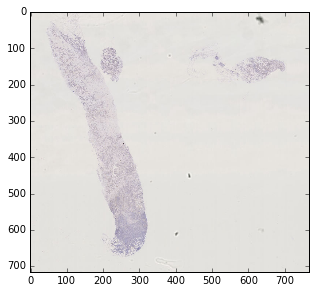

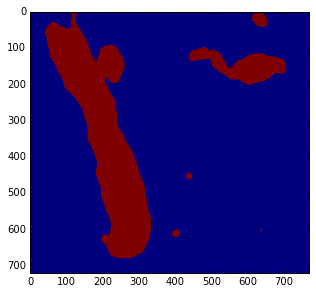

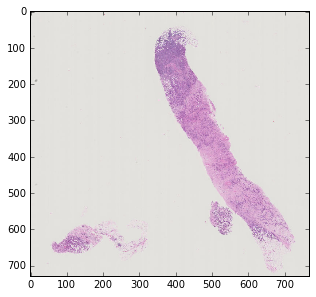

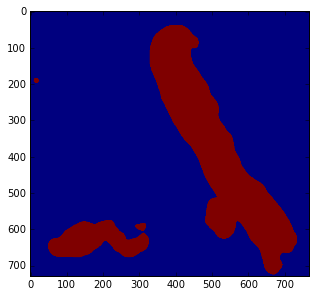

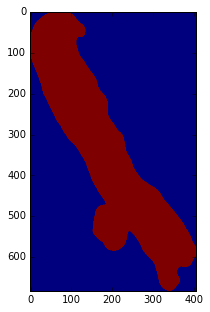

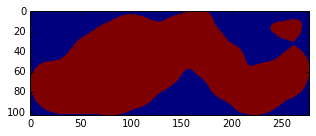

2054873856.0
0


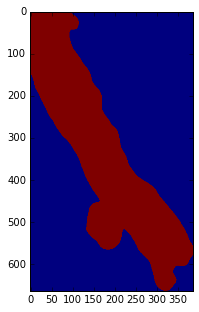

2119247872.0
2


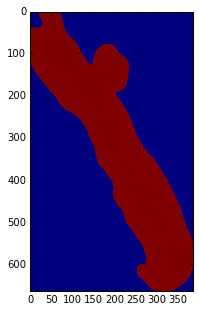

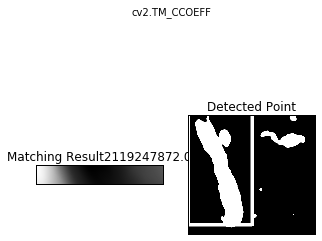

115283872.0
0


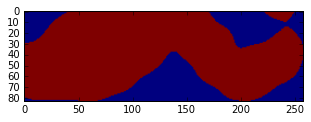

211082736.0
2


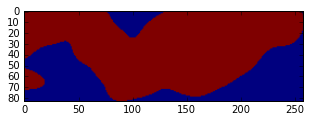

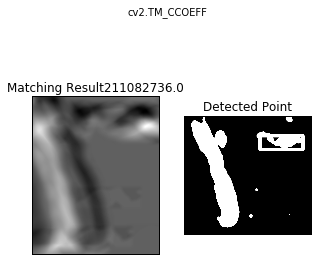

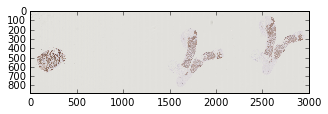

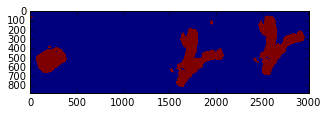

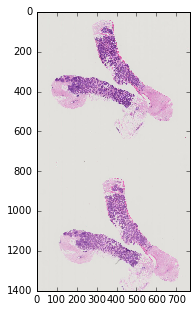

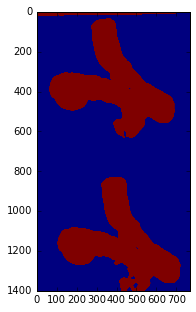

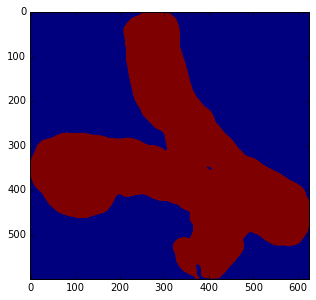

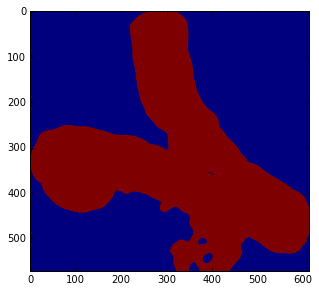

1758736896.0
0


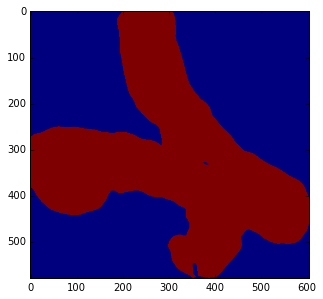

2059285504.0
1


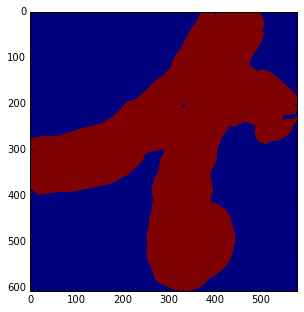

2183397888.0
2


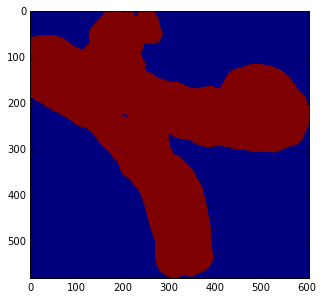

4483429888.0
3


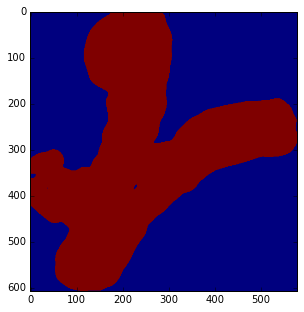

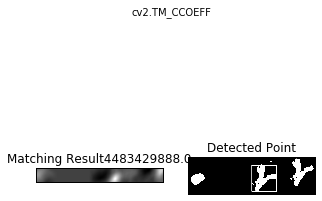

1682562176.0
0


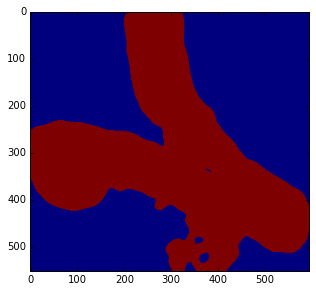

2020463872.0
1


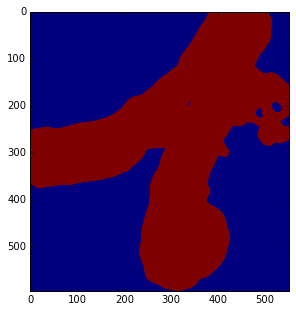

2194964992.0
2


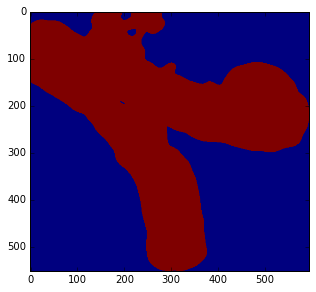

4156739072.0
3


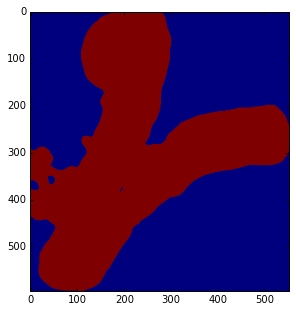

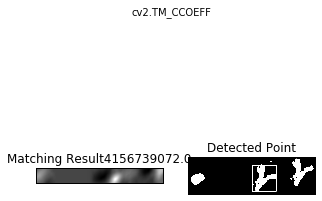

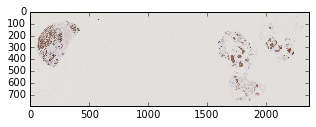

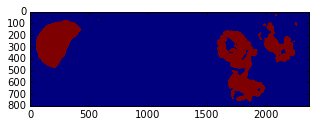

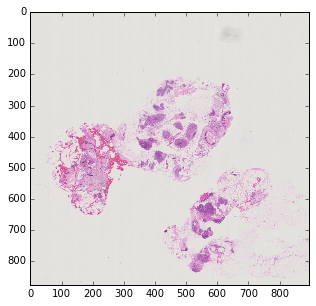

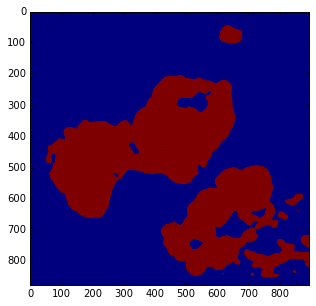

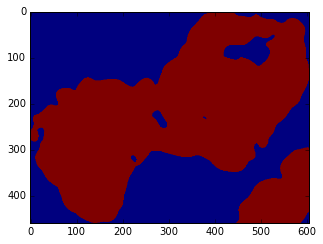

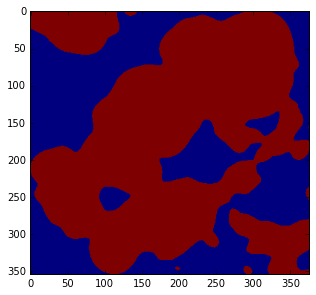

1325053952.0
0


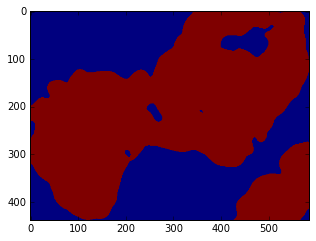

2419604224.0
1


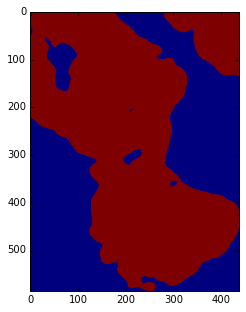

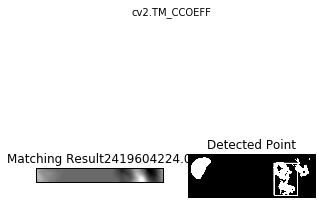

596421056.0
0


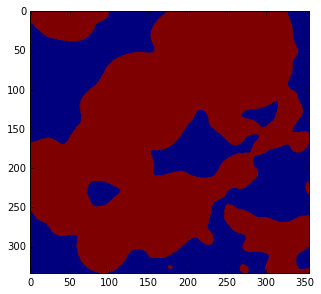

882446272.0
1


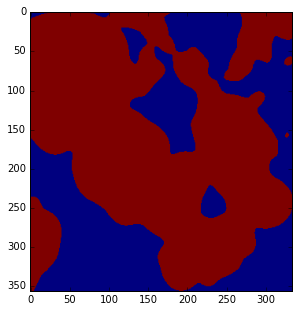

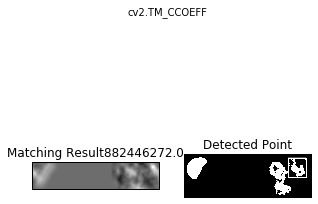

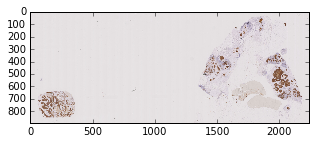

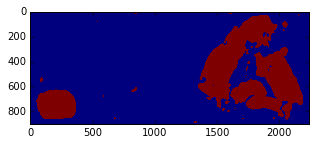

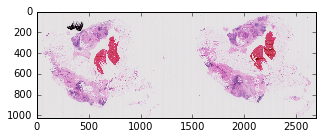

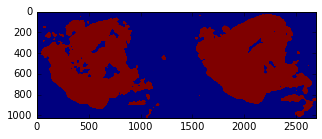

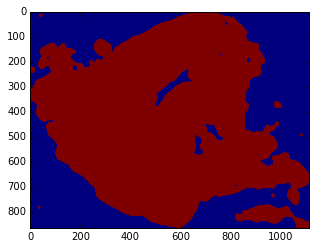

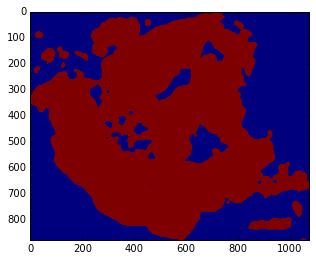

5378924032.0
0


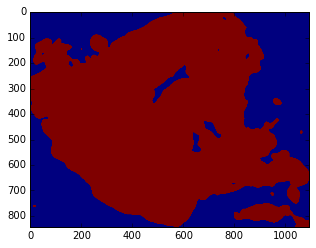

Trying next angle
5712073728.0
2


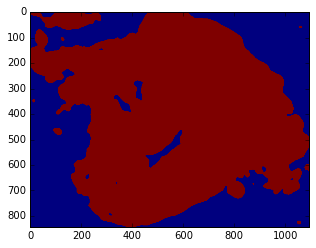

Trying next angle


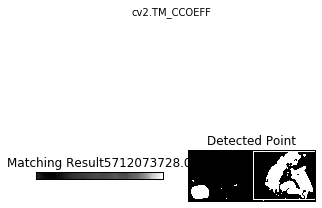

5235556864.0
0


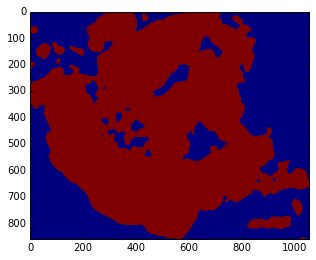

Trying next angle
Trying next angle


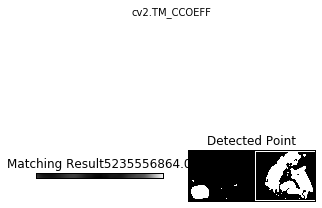

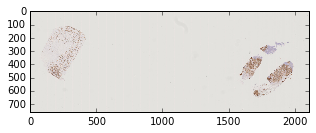

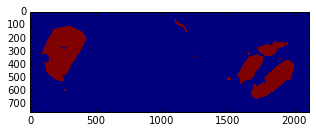

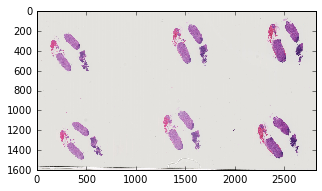

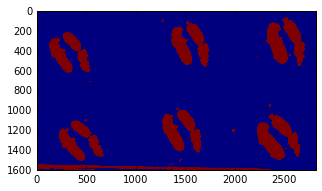

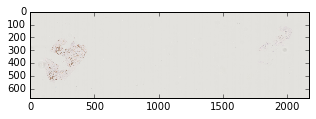

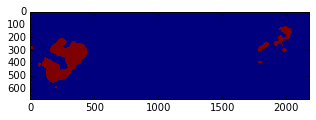

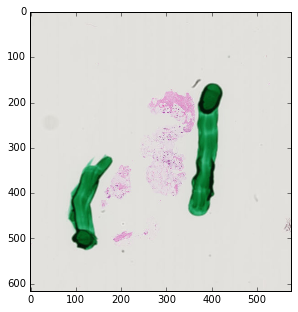

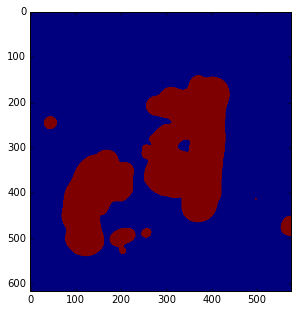

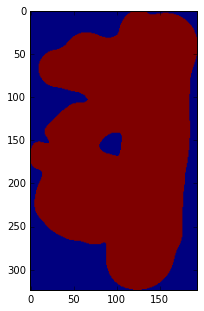

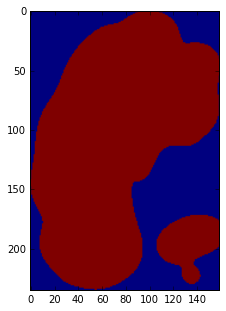

267254768.0
0


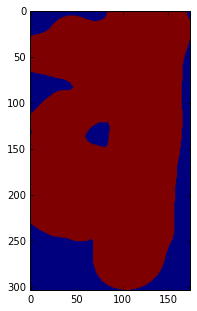

340187456.0
1


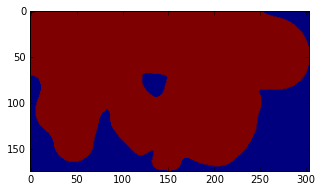

373202496.0
2


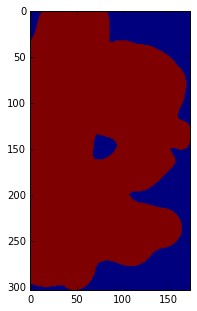

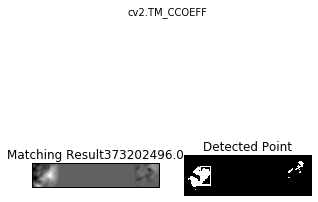

221486320.0
0


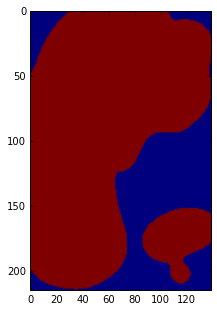

223348768.0
2


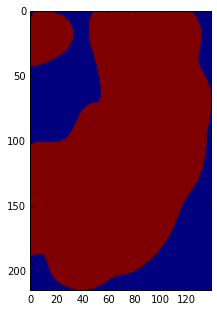

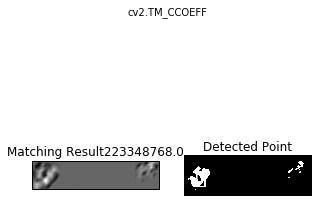

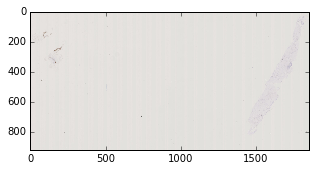

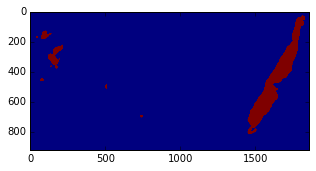

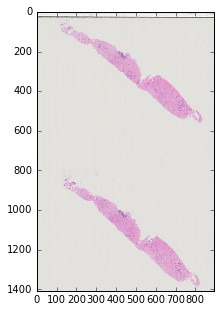

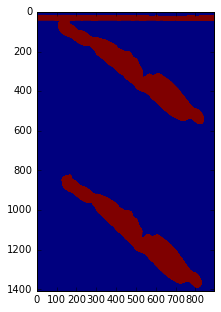

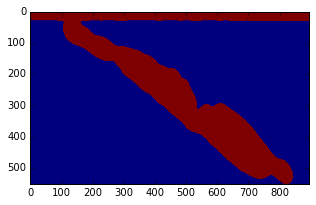

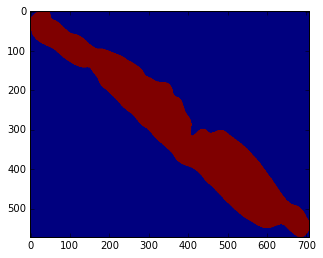

289400544.0
0


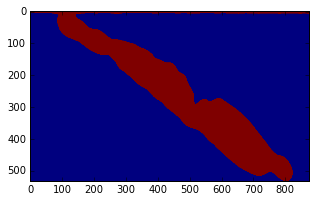

1202865408.0
1


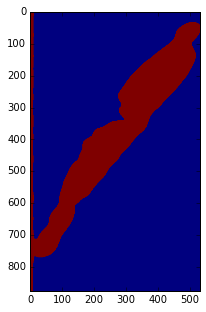

1911634432.0
3


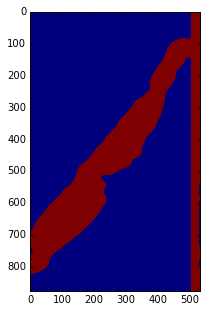

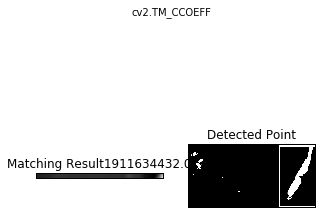

329558304.0
0


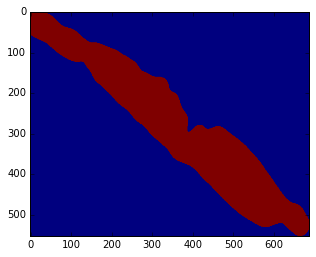

1763039360.0
1


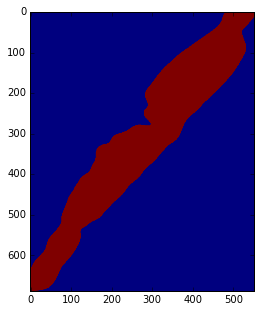

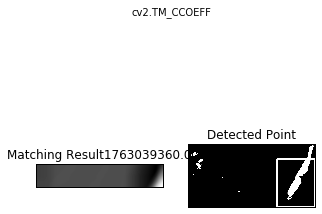

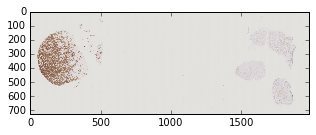

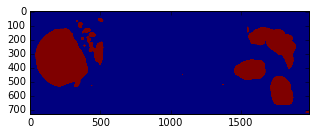

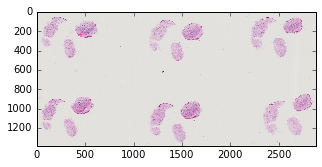

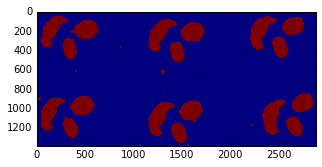

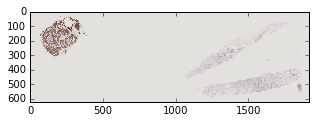

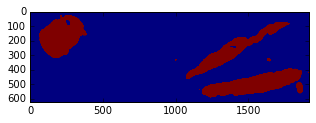

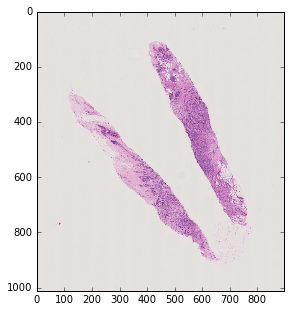

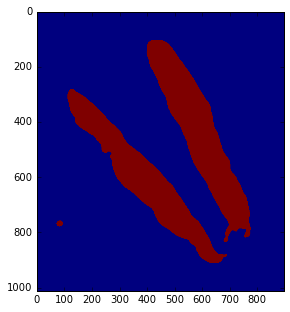

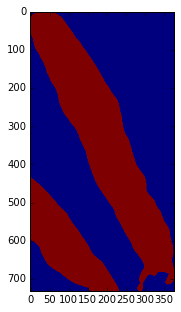

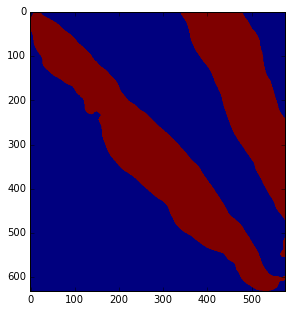

Trying next angle
1892119552.0
1


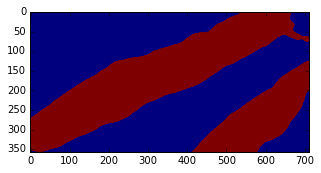

Trying next angle


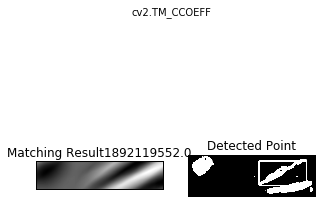

494329952.0
0


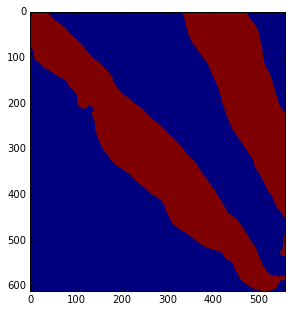

1012982912.0
1


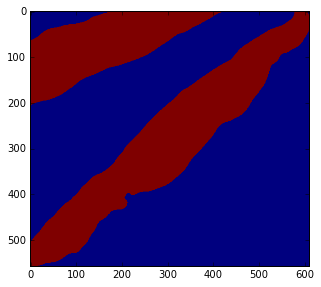

2403497728.0
3


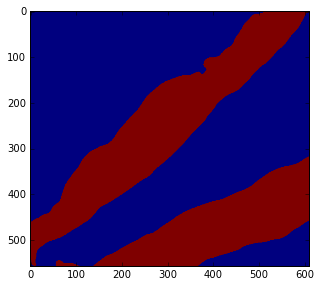

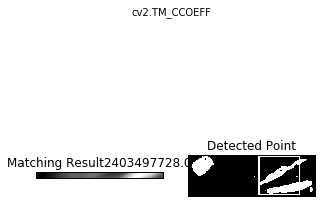

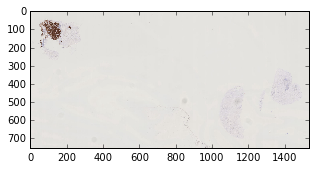

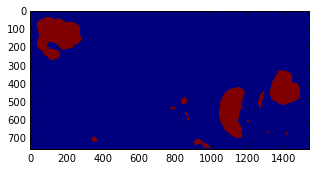

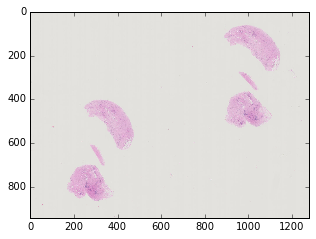

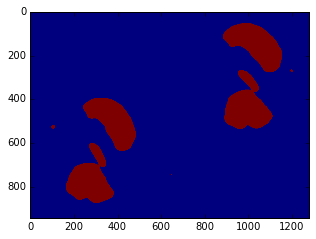

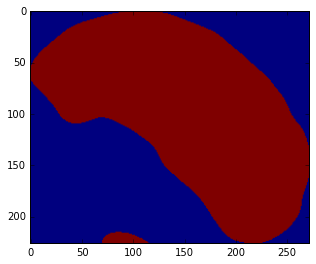

381070816.0
0


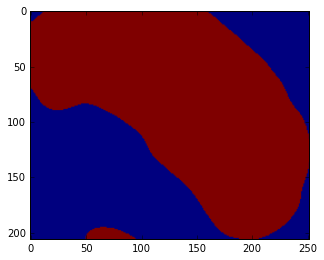

479722464.0
1


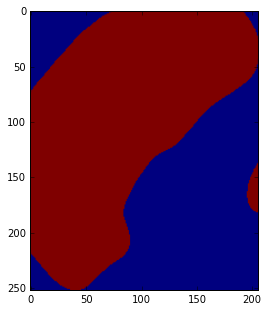

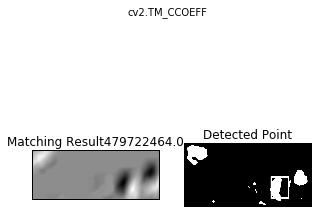

In [104]:
from scipy import ndimage

upscaleWindowSize = 40
upscaleLevel = 4

def getBlobs(img):
    blobs, numberOfBlobs = ndimage.label(img)
    
    objs = ndimage.find_objects(blobs)
    count = 0
    significantObjects = []
    for i in range(len(objs)):
        obj = objs[i]
        area = (obj[0].stop - obj[0].start)*(obj[1].stop - obj[1].start)

        if float(area)/img.size > 0.05:
            count += 1
            significantObjects.append(obj)
            plt.imshow(img[obj])
            plt.show()
    return significantObjects

def templateMatch(img,templateImg,templates):
    
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    
    for temp in templates:

        bestRotation = 0
        highestValue = 0
        
        for rotation in range(4):
            dst = np.rot90(templateImg[temp],rotation)
            template = dst[20:,20:]
            w, h = template.shape[::-1]
            try:
                for meth in methods[:1]:
                    #dst = np.rot90(dst,rotation)
                    img2 = img.copy()
                    method = eval(meth)

                    # Apply template Matching
                    res = cv2.matchTemplate(img2,template,method)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                    if max_val > highestValue:
                        highestValue = max_val
                        bestRotation = rotation
                        print(highestValue)
                        print(bestRotation)
                        plt.imshow(template)
                        plt.show()

                 
            except:
                print("Trying next angle")
                dst = np.rot90(templateImg[temp],rotation)
                
        dst = np.rot90(templateImg[temp],bestRotation)
        template = dst[20:,20:]
        w, h = template.shape[::-1]
        res = cv2.matchTemplate(img2,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv2.rectangle(img2,top_left, bottom_right, 255, 20)

        plt.subplot(121),plt.imshow(res,cmap = cm.gray)
        plt.title('Matching Result'+str(max_val)), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(img2,cmap = cm.gray)
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)
        plt.show()

for caseNo in groundTruth.CaseNo.values[:10]:

    threshMargin = 4
    eg = her2Image(caseNo,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize)
    plt.imshow(eg.lowResRGB)
    plt.show()
    plt.imshow(eg.thresh)
    plt.show()
    plt.imshow(eg.lowResRGBHE)
    plt.show()
    plt.imshow(eg.threshHE)
    plt.show()
    templates = getBlobs(eg.threshHE)
    templateMatch(eg.thresh,eg.threshHE,templates)